In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from datetime import datetime
import activations
import layers
import train

##the pounded comments were used to determine lambda by splitting my data into train and test set. I found lambda = 0 gave the least error

In [2]:
df = pd.read_excel(r'data.xlsx')

In [3]:
df_ = df
cont = list(df["continent"].unique())
cont.remove(cont[-1])                                  # to remove Nan
loc = list(df["location"].unique())
loc.remove('World')
loc.remove('International')
df = df.dropna(subset = ['continent', 'new_cases', 'new_deaths'])    # drop the rows if it has Nan in any of the 3 columns
copy = df
#'''to preserve the original dataframe'''

In [4]:
for continent in cont:
    df.loc[df.continent == continent, "continent"] = float(cont.index(continent) + 1)    #'''Asia=1, etc'''

c:\users\prem kumar\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [5]:
for location in loc:
    df.loc[df.location == location, "location"] = float(loc.index(location) + 1)
    arr=(df.loc[df.location == loc.index(location) + 1, ["date", "new_cases", "new_deaths", "continent", "location"]]).to_numpy()
    arr1 = arr[:,:3]
    arr1[1:,1:3]=arr[:-1,1:3]
                                                  #''' the date of nth row in a location shld match with new cases and death of n-1th location'''
    arr1 = arr1[1:,:]
    rows, columns = np.indices((np.size(arr1,0),1))
    arr1[rows, columns] = rows + 2
    arr1 = np.insert(arr1, 1, arr1[:,0]**2, axis=1)      # ''' i plotted new cases and deaths against number of days and found it to be a quadrtatic dependence'''
    if(loc.index(location) == 0):
        previous = arr1                                          #'''parsing location by location and preparing the input for layer 2'''
        #previous_train = arr1[:math.floor(0.8 * np.size(arr1,0)), :]
        #previous_test = arr1[math.floor(0.8 * np.size(arr1,0)):,:]

        Y=arr[1:,1:3]                                             #'''parsing location by location and preparing the output layer. '''
        #Y_train = arr[1:math.floor(0.8 * np.size(arr1,0))+1, 1:3]
        #Y_test = arr[math.floor(0.8 * np.size(arr1,0))+1:, 1:3]

        D=arr[1:,3:]                                               #'''parsing location by location and preparing the input for layer 1'''

        #D_train = arr[1:math.floor(0.8 * np.size(arr1,0))+1, 3:]
        #D_test = arr[math.floor(0.8 * np.size(arr1,0))+1:, 3:]

    else:
        #previous_train = np.vstack((previous_train, arr1[:math.floor(0.8 * np.size(arr1,0)), :]))
        #previous_test = np.vstack((previous_test, arr1[math.floor(0.8 * np.size(arr1,0)):,:]))
        previous = np.vstack((previous, arr1))    # second layer input

        #Y_train = np.vstack((Y_train, arr[1:math.floor(0.8 * np.size(arr1,0))+1, 1:3] ))
        #Y_test = np.vstack((Y_test, arr[math.floor(0.8 * np.size(arr1,0))+1:, 1:3]))
        Y = np.vstack((Y,arr[1:,1:3]))

        #D_train = np.vstack((D_train, arr[1:math.floor(0.8 * np.size(arr1,0))+1, 3:] ))
        #D_test = np.vstack((D_test, arr[math.floor(0.8 * np.size(arr1,0))+1:, 3:]))
        D = np.vstack((D,arr[1:,3:]))                                                 #''' first row of each location should be omitted because it doesnt have previous cases and deaths'''
#O = np.ones((np.size(D,0), 1))

In [13]:
epsilon = 10**(-4)
Theta1 = (np.random.rand(5,3)) * (2*epsilon) - epsilon   #''' 5x3 matrix whose absolute values are less than epsilon'''
Theta2 = (np.random.rand(7,10)) * (2*epsilon) - epsilon
Theta3 = (np.random.rand(5,8)) * (2*epsilon) - epsilon
Theta4 = (np.random.rand(2,6)) * (2*epsilon) - epsilon               #''' random initialization of weights'''
np.set_printoptions(threshold=np.inf)

In [7]:
D_Normed = layers.layer1(D)

#D_Normed, meanD, stdD = featureNormalize.fNorm(D_train)
#D_Normed_test, meanDtest, stdDtest = featureNormalize.fNorm(D_test)

previous_Normed, meanPre, stdPre = train.fNorm(previous)
#previous_Normed, meanPre, stdPre = featureNormalize.fNorm(previous_train)
#previous_Normed_test, meanPretest, stdPretest = featureNormalize.fNorm(previous_test)

Y_Normed=layers.layer5(Y)      #since input to second layer is normed lets norm this also
#Y_Normed, meanY, stdY = featureNormalize.fNorm(Y_train)
#Y_Normed_test, meanYtest, stdYtest = featureNormalize.fNorm(Y_test)

In [27]:
num_iters = 500.0
#Lambda = [0, 0.02 ** x for x in range(1,11)]
Lambda=0
lr = 0.6
J_hist = np.arange(num_iters)                                # ''' to plot it against num of iterations'''
#J_test_hist = []
#hypo_hist = np.zeros((27150, 2, int(num_iters)))
hypo_hist = np.zeros((np.size(Y_Normed.z, 0), 2, int(num_iters)))


In [28]:
#for Lambda_ in Lambda:   '''to check which lambda gives the smallest error'''

    #Theta1 = (np.random.rand(5,3)) * (2*epsilon) - epsilon
    #Theta2 = (np.random.rand(7,10)) * (2*epsilon) - epsilon
    #Theta3 = (np.random.rand(5,8)) * (2*epsilon) - epsilon
    #Theta4 = (np.random.rand(2,6)) * (2*epsilon) - epsilon      '''re initialize theta for every lambda_

for i in range(0,int(num_iters)):           # '''gradient descent'''
    #hypo_hist[:,:,i], J_hist[i], des1, des2, des3, des4, meanz1, stdz1, meanz2, stdz2, meanz3, stdz3  = hypothesis.hypothesis(matrix_lay1, previous_Normed, Y_Normed, Theta1, Theta2, Theta3, Theta4, num_iters, Lambda)
    hypo_hist[:,:,i], J_hist[i], des1, des2, des3, des4, meanz1, stdz1, meanz2, stdz2, meanz3, stdz3  = train.forBackprop(D_Normed.z, previous_Normed, Y_Normed.z, Theta1, Theta2, Theta3, Theta4, Lambda)
    Theta1[:,1:] = Theta1[:,1:] - lr*des1
    Theta2[:,1:] = Theta2[:,1:] - lr*des2
    Theta3[:,1:] = Theta3[:,1:] - lr*des3
    Theta4[:,1:] = Theta4[:,1:] - lr*des4
    if i%10 == 9 and i!=0:
        print(f"epoch: {i+1}, loss: {J_hist[i]}")

#J_test_hist.append(hypothesis.costTest(np.hstack((O[:np.size(D_Normed_test, 0), :], D_Normed_test)), previous_Normed_test, Y_Normed_test, Theta1, Theta2, Theta3, Theta4))


epoch: 10, loss: 1.2317620650062935
epoch: 20, loss: 1.2294427222511013
epoch: 30, loss: 1.2279754220828394
epoch: 40, loss: 1.308122506337531
epoch: 50, loss: 1.382318870537446
epoch: 60, loss: 1.3719187249373423
epoch: 70, loss: 1.8655779738380944
epoch: 80, loss: 1.774654581119919
epoch: 90, loss: 1.6071918013753745
epoch: 100, loss: 1.579827510623805
epoch: 110, loss: 1.6091162332230586
epoch: 120, loss: 1.4400313994896567
epoch: 130, loss: 1.2576056718941153
epoch: 140, loss: 1.144432147900982
epoch: 150, loss: 1.0946158962256989
epoch: 160, loss: 1.0588185089701552
epoch: 170, loss: 1.0300644265962537
epoch: 180, loss: 1.0062913234281958
epoch: 190, loss: 1.0822103359284598
epoch: 200, loss: 1.0617706092373473
epoch: 210, loss: 1.0200416771282084
epoch: 220, loss: 0.989127438759584
epoch: 230, loss: 0.9652365319858969
epoch: 240, loss: 1.0633242393256899
epoch: 250, loss: 1.0205924073756527
epoch: 260, loss: 0.9896809863886293
epoch: 270, loss: 0.9659748185301692
epoch: 280, loss

In [29]:
weight1 = Theta1.reshape((np.size(Theta1), 1))
weight2 = Theta2.reshape((np.size(Theta2), 1))
weight3 = Theta3.reshape((np.size(Theta3), 1))
weight4 = Theta4.reshape((np.size(Theta4), 1))
with open(r'weights.npy', 'w') as f:
    np.save(r'weights.npy', np.vstack((weight1, weight2, weight3, weight4)))
with open(r'norm.npy', 'w') as f:
    np.save(r'norm.npy', np.hstack((D_Normed.mean, D_Normed.std, meanPre, stdPre, meanz1, stdz1, meanz2, stdz2, meanz3, stdz3, Y_Normed.mean, Y_Normed.std)))

In [30]:
#print(J_test_hist)
#plt.plot(list(range(0, len(Lambda) )), J_test_hist)
#plt.title(lr)
#plt.show()
#print((np.multiply(hypo_hist[:10,:,-1], Y_Normed.std) + Y_Normed.mean ))
print()
#print(Y_Normed.mean, Y_Normed.std)
print(hypo_hist[:20,:,-1])
print(Y_Normed.z[:20,:])
#dataframe = pd.DataFrame(np.hstack((Y, (np.multiply(hypo_hist[:,:,-1], stdY) + meanY ))))
#writer = pd.ExcelWriter(r'E:\Prem\python\spyder\train0.xlsx', engine='xlsxwriter')
#dataframe.to_excel(writer)
#writer.save()


[[0.04267505 0.02045256]
 [0.04267505 0.02045256]
 [0.04267505 0.02045256]
 [0.04267505 0.02045256]
 [0.04267505 0.02045256]
 [0.04267505 0.02045256]
 [0.04267505 0.02045256]
 [0.04267505 0.02045256]
 [0.04267505 0.02045256]
 [0.04267505 0.02045256]
 [0.04267505 0.02045256]
 [0.04267505 0.02045256]
 [0.04267505 0.02045256]
 [0.04267505 0.02045256]
 [0.04267505 0.02045256]
 [0.04267505 0.02045256]
 [0.04267505 0.02045256]
 [0.04267505 0.02045256]
 [0.04267505 0.02045256]
 [0.04267505 0.02045256]]
[[-0.160402163051491 -0.1662567056275697]
 [-0.160402163051491 -0.1662567056275697]
 [-0.160402163051491 -0.1662567056275697]
 [-0.160402163051491 -0.1662567056275697]
 [-0.160402163051491 -0.1662567056275697]
 [-0.160402163051491 -0.1662567056275697]
 [-0.160402163051491 -0.1662567056275697]
 [-0.160402163051491 -0.1662567056275697]
 [-0.160402163051491 -0.1662567056275697]
 [-0.160402163051491 -0.1662567056275697]
 [-0.160402163051491 -0.1662567056275697]
 [-0.160402163051491 -0.166256705627

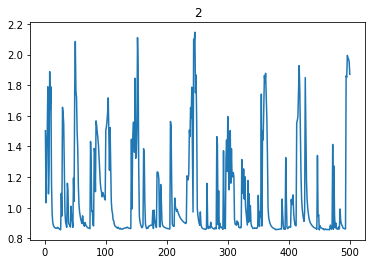

In [22]:
plt.plot(list(range(1, int(num_iters) + 1)), list(J_hist))
plt.title(lr)
plt.show()

In [ ]:
import load_weights
import numpy as np
import math
import activations

In [ ]:
cont_input = input(str("enter the continent"))
cont_input_float = float(cont.index(cont_input) + 1)
loc_input = input(str("enter the country"))
loc_input_float = float(loc.index(loc_input) + 1)
row = (df.loc[df.location == loc_input_float, ["date", "new_cases", "new_deaths"]]).to_numpy()

day_input = input(str("enter the date"))
date_format = "%d-%m-%Y"
a = datetime.strptime(day_input, date_format)

delta = a - row[-1,0]

In [ ]:
days_needed = np.arange(np.size(row, 0) + 2, np.size(row,0) + 2 + delta.days, dtype=np.float32)

A = np.array([cont_input_float, loc_input_float], dtype=np.float32)

A = np.divide(A - D_Normed.mean, D_Normed.std)
A = np.insert(A,0,1,axis=0)

prev_case = row[-1,1]
prev_deaths = row[-1,2]
prev_case = (prev_case-load_weights.meanY[0])/load_weights.stdY[0]
prev_deaths = (prev_deaths-load_weights.meanY[1])/load_weights.stdY[1]

In [ ]:
for i in days_needed:
    
    calc1 = activations.activation(A, load_weights.Theta1)

    calc1_ = np.hstack((calc1, np.array([i, i**2, prev_case, prev_deaths]) ))

    calc1Normed = np.divide(calc1_ - load_weights.meanz1 , load_weights.stdz1)

    calc1_Normed = np.insert(calc1Normed,0,1,axis=0)

    calc2 = activations.activation(calc1_Normed, load_weights.Theta2)
    calc2Normed = np.divide(calc2 - load_weights.meanz2, load_weights.stdz2)
    calc2_Normed = np.insert(calc2Normed,0,1,axis=0)

    calc3 = activations.activation(calc2_Normed, load_weights.Theta3)
    calc3Normed = np.divide(calc3 - load_weights.meanz3, load_weights.stdz3)
    calc3_Normed = np.insert(calc3Normed,0,1,axis=0)

    calc4 = activations.activation(calc3_Normed, load_weights.Theta4)
    
    prev_case, prev_deaths = calc4

In [ ]:
                                                     #''' we shld give normalized input again if we unnormalize here. so we can leave it as it is'''
pred_cases, pred_deaths = np.multiply(np.floor(np.fabs(calc4.astype(np.float64), dtype=np.float64)), load_weights.stdY) + load_weights.meanY #unnorming
print("the predicated new cases and deaths is ", pred_cases, pred_deaths)
